In [7]:
%matplotlib inline

import os

import gym
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

from models.vae import get_vae
from models.rnn import get_rnn

# Visualize VAE Recreation

In [9]:
data_shape = (144, 144, 3)
latent_dim = 32
data_dir = 'data/'
vae_checkpoint_path = 'checkpoints/vae.h5'
num_images = 5
output_file_vae = 'vae.png'

In [5]:
vae = get_vae(data_shape, latent_dim,
              filters=[16, 32, 64, 128, 256],
              kernels=[4, 4, 4, 4, 4],
              strides=[2, 2, 2, 2, 2],
              deconv_filters=[256, 128, 64, 32, 16, 3],
              deconv_kernels=[2, 5, 4, 4, 5, 4],
              deconv_strides=[2, 2, 2, 2, 2, 2])
vae.load_weights(vae_checkpoint_path)

In [20]:
filelist = os.listdir(data_dir)
filelist.sort()
filename = filelist[0]
obs = np.load(os.path.join(data_dir, filename))['obs'].astype(np.float) / 255.
np.random.shuffle(obs)
obs = obs[:num_images]
predictions = vae.predict(obs)

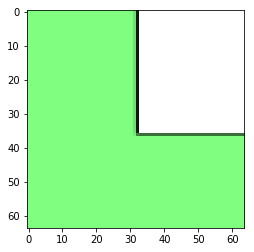

In [28]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 15))
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[0].set_title('Original Image')
    ax[1].imshow(gen, interpolation='nearest')
    ax[1].set_title('Autoencoder Recreation')
plt.savefig(output_file_vae)

# Visualize RNN Prediction

In [ ]:
rnn_checkpoint_path = 'checkpoints/rnn.h5'
output_file_rnn = 'rnn.png'
offset = 20

In [ ]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
decoder = Model(inputs=vae.get_layer('decoder').input,
                outputs=vae.get_layer('decoder').output)

In [ ]:
rnn_train, rnn_infer = get_rnn((None, 35))
rnn_train.load_weights(rnn_checkpoint_path)

In [ ]:
filelist = os.listdir(data_dir)
filelist.sort()
filename = filelist[0]
raw_data = np.load(os.path.join(data_dir, filename))
obs = raw_data['obs'].astype(np.float) / 255.
actions = raw_data['action']
obs = obs[offset:offset+num_images]

In [ ]:
z_true = encoder.predict(obs)[-1]
rnn_input = np.column_stack([z_true, actions])[:-1]
rnn_input = np.reshape(rnn_input, (-1, 1, 35))
z_pred = rnn_train.predict(rnn_input)

In [ ]:
# Sample predictions
num_mixtures = 5
output_sequence_width = 32
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]
# Extract flattened variables
logpis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
sigmas_flat.shape
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
logpis = np.reshape(logpis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Tempearture stuff
temperature = 0.7
logpistemp = np.copy(logpis)/temperature
logpistemp -= logpistemp.max()
pistemp = np.exp(logpistemp)
pistemp /= pistemp.sum(axis=2, keepdims=True)
pitemp = pistemp[:,0,:,:]
mu = mus[:,0,:,:]
sigma = sigmas[:,0,:,:]

In [ ]:
def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [ ]:
pi_idx = np.zeros((pitemp.shape[0], 32))
chosen_mu = np.zeros((pitemp.shape[0], 32))
chosen_sigma = np.zeros((pitemp.shape[0], 32))
for i in range(pitemp.shape[0]):
    for j in range(32):
        idx = get_pi_idx(np.random.rand(), pitemp[i][:,j])
        pi_idx[i,j] = idx
        chosen_mu[i,j] = mu[i][idx][j]
        chosen_sigma[i,j] = sigma[i][idx][j]

rand_gaussian = np.random.normal(size=(pitemp.shape[0], 32))*np.sqrt(temperature)
next_z = chosen_mu+chosen_sigma*rand_gaussian

In [ ]:
predictions = decoder.predict(next_z)
predictions_real = decoder.predict(z_true)

In [ ]:
fig, axes = plt.subplots(5, 2)
for ax, im, gen in zip(axes, predictions_real[1:], predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[0].set_title('Actual Image')
    ax[1].imshow(gen, interpolation='nearest')
    ax[1].set_title('Decoded RNN Prediction')
plt.savefig(output_file_rnn)